In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stat
import statsmodels.api as sm
import scikit_posthocs as sp

pd.set_option('display.max_columns', 9999)

%matplotlib inline

## Data Cleaning

In [2]:
# finding all opioids and nsaids given to patients

opioids = ['hydromorphone','hydrocodone','morphine','oxycodone','oxymorphone','codeine','fentanyl','meperidine',
          'tramadol','carfentanil','percocet','norco']

nsaids = ['acetaminophen','amitriptyline', 'doxepin', 'imipramine', 'desipramine', 'nortriptyline',
         'ibuprofen', 'naproxen', 'diclofenac', 'piroxicam', 'sulindac', 'indomethacin', 'ketorolac', 'meloxicam', 
          'celecoxib', 'ketoprofen', 'oxaprozin', 'toradol', 'valdecoxib', 'bextra', 'rofecoxib', 'vioxx', 'gabapentin', 
          'neurontin', 'cyclobenzaprine', 'duloxetine', 'cymbalta', 'pregabalin', 'lyrica', 'venlafaxine', 'effexor', 
          'tylenol', 'voltaren', 'naprosyn', 'paracetamol', 'aspirin']


def opioids_nsaids (x, li):

    for i in li:
        if i in str(x).lower():
            return 1
        
    return 0

In [3]:
med = pd.read_csv('eicu-collaborative-research-database-2.0/medication.csv.gz')
pts = pd.read_csv('eicu-collaborative-research-database-2.0/patient.csv.gz')
hos = pd.read_csv('eicu-collaborative-research-database-2.0/hospital.csv.gz')

/Users/adeshkadambi/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
med = med[med.drugordercancelled == 'No']

cols_drop = ['medicationid',
             'drugorderoffset',
             'drugivadmixture',
             'drugordercancelled',
             'drughiclseqno',
             'routeadmin',
             'loadingdose',
             'prn',
             'gtc'
            ]

med.drop(columns=cols_drop, inplace=True)

med['opioid'] = med.drugname.apply(lambda x: opioids_nsaids(x, opioids))
med['nsaid'] = med.drugname.apply(lambda x: opioids_nsaids(x, nsaids))

med = med[(med.opioid == 1) | (med.nsaid == 1)]

mg = med.groupby(['patientunitstayid']).agg({'opioid': lambda x:sum(x), 'nsaid': lambda x:sum(x)})
mg[mg != 0] = 1

In [5]:
def op_find (x, arr):
    try:
        return arr['opioid'][x]
    except:
        return np.nan
    
def nsaid_find (x, arr):
    try:
        return arr['nsaid'][x]
    except:
        return np.nan

In [6]:
pts = pts[pts.gender != 'Unknown']
pts = pts[pts.gender != 'Other']

pts['opioid'] = pts['patientunitstayid'].apply(lambda x: op_find(x, mg))
pts['nsaid'] = pts['patientunitstayid'].apply(lambda x: nsaid_find(x, mg))

pts = pd.merge(pts, hos, on=['hospitalid'], how = 'left')

In [7]:
# fill missing values

pts['apacheadmissiondx'].fillna(value = 'N/A', inplace = True)
pts['hospitaladmitsource'].fillna(value = 'Unknown', inplace = True)

def age (x):
    if x == '> 89':
        return 90
    else:
        return int(x)

pts['age'].fillna(value = 0, inplace = True)
pts['age'] = pts['age'].apply(lambda x: age(x))

pts.opioid.fillna(0, inplace = True)
pts.nsaid.fillna(0, inplace = True)

pts.opioid.replace(1.0,True,inplace=True)
pts.opioid.replace(0.0,False,inplace=True)

pts.nsaid.replace(1.0,True,inplace=True)
pts.nsaid.replace(0.0,False,inplace=True)

pts['painmeds'] = pts.opioid|pts.nsaid

In [8]:
pts.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,hospitaldischargelocation,hospitaldischargestatus,unittype,unitadmittime24,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid,opioid,nsaid,numbedscategory,teachingstatus,region,painmeds
0,141168,128919,Female,70,Caucasian,59,91,"Rhythm disturbance (atrial, supraventricular)",152.4,15:54:00,0,Direct Admit,2015,03:50:00,3596,Death,Expired,Med-Surg ICU,15:54:00,Direct Admit,1,admit,84.3,85.8,03:50:00,3596,Death,Expired,002-34851,True,True,<100,f,Midwest,True
1,141178,128927,Female,52,Caucasian,60,83,N/A,162.6,08:56:00,-14,Emergency Department,2015,19:20:00,2050,Home,Alive,Med-Surg ICU,09:10:00,Emergency Department,1,admit,54.4,54.4,09:18:00,8,Step-Down Unit (SDU),Alive,002-33870,False,True,<100,f,Midwest,True
2,141179,128927,Female,52,Caucasian,60,83,N/A,162.6,08:56:00,-22,Emergency Department,2015,19:20:00,2042,Home,Alive,Med-Surg ICU,09:18:00,ICU to SDU,2,stepdown/other,NaN,60.4,19:20:00,2042,Home,Alive,002-33870,False,False,<100,f,Midwest,False
3,141194,128941,Male,68,Caucasian,73,92,"Sepsis, renal/UTI (including bladder)",180.3,18:18:40,-780,Floor,2015,23:30:00,12492,Home,Alive,CTICU,07:18:00,Floor,1,admit,73.9,76.7,15:31:00,4813,Floor,Alive,002-5276,True,True,>= 500,t,Midwest,True
4,141196,128943,Male,71,Caucasian,67,109,N/A,162.6,20:21:00,-99,Emergency Department,2015,17:00:00,5460,Home,Alive,Med-Surg ICU,22:00:00,ICU to SDU,2,stepdown/other,NaN,63.2,22:23:00,1463,Floor,Alive,002-37665,True,True,NaN,f,Midwest,True


In [ ]:
pts.to_csv('final_patients.csv')

## Plotting
Ethnicity vs. Pain Medication Administration (Either, NSAID Only, Opioid Only)

In [ ]:
plt.figure(figsize=(14, 4.5))
sns.barplot(x='ethnicity',y='painmeds',data=pts, estimator=np.mean)
plt.xlabel('Patient Ethnicity')
plt.ylabel('Proportion Receiving Pain Medications')

In [ ]:
plt.figure(figsize=(14, 4.5))
sns.barplot(x='ethnicity',y='nsaid',data=pts, estimator=np.mean)
plt.xlabel('Patient Ethnicity')
plt.ylabel('Proportion Receiving NSAIDs')

In [ ]:
plt.figure(figsize=(14, 4.5))
sns.barplot(x='ethnicity',y='opioid',data=pts, estimator=np.mean)
plt.xlabel('Patient Ethnicity')
plt.ylabel('Proportion Receiving Opioids')

## Checking Significance
Chi-squared testing

### Test 1:
H<sub>0</sub>: Pain medication administration is independent of patient ethnicity.  
H<sub>1</sub>: Pain medication administration is not independent of patient ethnicity.

In [ ]:
ct_eth = pd.crosstab(pts.painmeds, pts.ethnicity)
ct_eth

In [ ]:
c, p, dof, expected = stat.chi2_contingency(ct_eth)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

In [ ]:
# We conclude there is a relationship between pain meds and ethnicity.

___
##### Checking between groups

In [ ]:
c_aa_ = ct_eth[['African American','Caucasian']]
c_aa_

In [ ]:
c, p, dof, expected = stat.chi2_contingency(c_aa_)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

___
### Test 2:
H<sub>0</sub>: NSAID administration is independent of patient ethnicity.  
H<sub>1</sub>: NSAID administration is not independent of patient ethnicity.

In [ ]:
ct_ns = pd.crosstab(pts.nsaid, pts.ethnicity)
ct_ns

In [ ]:
c, p, dof, expected = stat.chi2_contingency(ct_ns)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

In [ ]:
c_aa_ns = ct_ns[['African American','Caucasian']]
c_aa_ns # do for all groups

In [ ]:
c, p, dof, expected = stat.chi2_contingency(c_aa_ns)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

In [ ]:
# We conclude there is a relationship between NSAIDs and ethnicity.

##### Test 3:
H<sub>0</sub>: Opioid administration is independent of patient ethnicity.  
H<sub>1</sub>: Opioid administration is not independent of patient ethnicity.

In [ ]:
ct_op = pd.crosstab(pts.opioid, pts.ethnicity)
ct_op

In [ ]:
c, p, dof, expected = stat.chi2_contingency(ct_op)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

In [ ]:
c_aa = ct_op[['African American','Caucasian']]
c_aa # do for all groups

In [ ]:
c, p, dof, expected = stat.chi2_contingency(c_aa)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

In [ ]:
# We conclude there is a relationship between Opioids and ethnicity.

___
### Morphine Equivalence Analysis

In [9]:
opi = pd.read_csv('opioids_final.csv')
opi = pd.merge(opi, pts, on=['patientunitstayid'], how = 'left')

In [10]:
opi['mme_test'] = (opi.dos_mg.multiply(opi.doses_per_day)).multiply(opi.mme)

In [11]:
opi['mme_per_day']= np.multiply(opi['dos_mg'],opi['doses_per_day'])
opi['mme_per_day']= np.multiply(opi['mme_per_day'],opi['mme'])

In [12]:
opi.head()

,patientunitstayid,drugstartoffset,opioid_x,nsaid_x,dos_mg,doses_per_day,durations_days,mme,mme_per_day,mme_total,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,hospitaldischargelocation,hospitaldischargestatus,unittype,unitadmittime24,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid,opioid_y,nsaid_y,numbedscategory,teachingstatus,region,painmeds,mme_test
0,141168,2028.0,1.0,0.00,2.50,288.0,0.251389,2.4,1728.0000,434.400000,128919.0,Female,70.0,Caucasian,59.0,91.0,"Rhythm disturbance (atrial, supraventricular)",152.4,15:54:00,0.0,Direct Admit,2015.0,03:50:00,3596.0,Death,Expired,Med-Surg ICU,15:54:00,Direct Admit,1.0,admit,84.3,85.8,03:50:00,3596.0,Death,Expired,002-34851,True,True,<100,f,Midwest,True,1728.0000
1,141194,93.5,1.0,0.25,1.65,147.5,4.130556,2.5,608.4375,97.219097,128941.0,Male,68.0,Caucasian,73.0,92.0,"Sepsis, renal/UTI (including bladder)",180.3,18:18:40,-780.0,Floor,2015.0,23:30:00,12492.0,Home,Alive,CTICU,07:18:00,Floor,1.0,admit,73.9,76.7,15:31:00,4813.0,Floor,Alive,002-5276,True,True,>= 500,t,Midwest,True,608.4375
2,141196,-31.0,1.0,0.00,1.00,6.0,3.897917,4.0,24.0000,93.550000,128943.0,Male,71.0,Caucasian,67.0,109.0,N/A,162.6,20:21:00,-99.0,Emergency Department,2015.0,17:00:00,5460.0,Home,Alive,Med-Surg ICU,22:00:00,ICU to SDU,2.0,stepdown/other,NaN,63.2,22:23:00,1463.0,Floor,Alive,002-37665,True,True,NaN,f,Midwest,True,24.0000
3,141203,1873.0,1.0,0.00,2.00,96.0,1.608333,1.0,192.0000,308.800000,128948.0,Female,77.0,Caucasian,66.0,90.0,"Arrest, respiratory (without cardiac arrest)",160.0,22:23:00,-1336.0,Floor,2014.0,16:22:00,4063.0,Other External,Alive,Med-Surg ICU,20:39:00,Floor,1.0,admit,70.2,70.3,03:48:00,1869.0,Floor,Alive,002-23234,True,True,100 - 249,f,Midwest,True,192.0000
4,141227,394.5,1.0,0.00,3.50,1.0,0.025694,1.0,3.5000,0.117014,128968.0,Male,82.0,Caucasian,60.0,83.0,"Sepsis, pulmonary",185.4,19:19:00,-1004.0,Floor,2015.0,16:35:00,1712.0,Other Hospital,Alive,Med-Surg ICU,12:03:00,Floor,1.0,admit,82.2,82.2,15:35:00,1652.0,Other Hospital,Alive,002-21459,True,True,<100,f,Midwest,True,3.5000


In [13]:
opi_stat = opi[['patientunitstayid','mme_per_day']]
#opi_stat.fillna(value='Other/Unknown', inplace=True)

opi_stat.head()

,patientunitstayid,mme_per_day
0,141168,1728.0000
1,141194,608.4375
2,141196,24.0000
3,141203,192.0000
4,141227,3.5000


In [ ]:
opi.describe()

In [ ]:
opi[opi.mme_test < 0]

In [ ]:
sns.displot(opi_stat, x='mme_per_day', aspect=5, height=8)

In [ ]:
plt.figure(figsize=(14, 4.5))
sns.barplot(x='ethnicity',y='mme_per_day',data=opi_stat, estimator=np.mean)
plt.xlabel('Ethnicity')
plt.ylabel('MME per Day')

In [ ]:
# Testing for Normal Distribution

opi_stat_c = list(opi_stat[opi_stat.ethnicity == 'Caucasian'].mme_per_day)
opi_stat_aa = list(opi_stat[opi_stat.ethnicity == 'African American'].mme_per_day)
opi_stat_a = list(opi_stat[opi_stat.ethnicity == 'Asian'].mme_per_day)
opi_stat_h = list(opi_stat[opi_stat.ethnicity == 'Hispanic'].mme_per_day)
opi_stat_na = list(opi_stat[opi_stat.ethnicity == 'Native American'].mme_per_day)
opi_stat_o = list(opi_stat[opi_stat.ethnicity == 'Other/Unknown'].mme_per_day)

k_c, p_c = stat.kstest(opi_stat_c, 'norm')
k_aa, p_aa = stat.kstest(opi_stat_aa, 'norm')
k_a, p_a = stat.kstest(opi_stat_a, 'norm')
k_h, p_h = stat.kstest(opi_stat_h, 'norm')
k_na, p_na = stat.kstest(opi_stat_na, 'norm')
k_o, p_o = stat.kstest(opi_stat_o, 'norm')

print('Caucasian: k-value:', k_c, 'p-value:', p_c)
print('African America: k-value:', k_aa, 'p-value:', p_aa)
print('Asian: k-value:', k_a, 'p-value:', p_a)
print('Hispanic: k-value:', k_h, 'p-value:', p_h)
print('Native American: k-value:', k_na, 'p-value:', p_na)
print('Other: k-value:', k_o, 'p-value:', p_o)

In [ ]:
# Non-normal distributions, using non-parametric Kruskal-Wallis H-test

stat.kruskal(opi_stat_c,opi_stat_aa,opi_stat_a,opi_stat_h,opi_stat_na,opi_stat_o)

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Multiple pairwise comparison (Tukey HSD) - whats the nonparametric equivalent?

m_comp = pairwise_tukeyhsd(endog=opi_stat['mme_per_day'], groups=opi_stat['ethnicity'], alpha=0.05)
m_comp.summary()

In [ ]:
nemenyi = sp.posthoc_nemenyi(opi_stat, 'mme_per_day', 'ethnicity')
nemenyi

In [ ]:
# Bonferroni correction

pvals = [] # grab pvals from nemenyi df above by columns

for i in nemenyi.columns:
    pvals = pvals + list(nemenyi[i])

from statsmodels.stats.multitest import multipletests

p_adjusted = multipletests(pvals, alpha=0.05, method='bonferroni')

In [ ]:
print('Corrected alpha for Bonferroni method: ', p_adjusted[3])

In [ ]:
group1 = []
group2 = []

for col in nemenyi.columns:
    for row in nemenyi.index:
        group1.append(col)
        group2.append(row)

In [ ]:
d = {'group1': group1, 'group2': group2, 'p_vals': p_adjusted[1], 'reject': p_adjusted[0]}

nemenyi_comp = pd.DataFrame(data=d)

In [ ]:
nemenyi_comp

In [ ]:
# Still need to remove duplicates 
# (i.e., group1 = African American, group2 = Caucasian &  group1 = Caucasian, group2 = African American)

### Chi Square for Specific Groups

In [105]:
opi_eth = pd.get_dummies(pts, columns=['ethnicity'])

In [106]:
opi_eth.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,hospitaldischargelocation,hospitaldischargestatus,unittype,unitadmittime24,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid,opioid,nsaid,numbedscategory,teachingstatus,region,painmeds,apachescore,actualventdays,gcs_score,from_OR,heartrate,hr_over100,ICU_duration,BMI,Antibiotic cycling,Cerebral vasospasm prevention/therapy,Congestive Heart Failure (CHF),Electrolyte replacement,End of life,Glucose control,Hypothermia,Lung protective ventilation,Myocardial infarction,Other,Pressure ulcer prophylaxis,Sedation,Sepsis bundle,Spinal precautions,Steroid taper,Tissue Plasminogen Activator (tPA),Ventilator bundle,Ventilator wean,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown
0,154752,139450.0,Male,53.0,73.0,100.0,"CVA, cerebrovascular accident/stroke",182.9,18:22:13,-32.0,Emergency Department,2015.0,16:58:00,9964.0,Rehabilitation,Alive,Neuro ICU,18:54:00,Emergency Department,1.0,admit,113.4,115.6,21:30:00,1596.0,Floor,Alive,002-57840,True,True,>= 500,t,Midwest,True,86.0,0.0,3.0,False,70.0,False,1.130556,33.898903,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
1,156771,140989.0,Female,88.0,63.0,95.0,"CVA, cerebrovascular accident/stroke",152.4,17:15:00,-14.0,Direct Admit,2014.0,18:26:00,14457.0,Skilled Nursing Facility,Alive,Med-Surg ICU,17:29:00,Direct Admit,1.0,admit,64.6,74.9,05:33:00,724.0,Floor,Alive,002-27764,True,True,100 - 249,f,Midwest,True,42.0,0.0,14.0,False,60.0,False,0.512500,27.813945,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,173247,153714.0,Female,81.0,73.0,100.0,"CVA, cerebrovascular accident/stroke",154.9,16:32:17,-12.0,Emergency Department,2015.0,17:32:00,8688.0,Rehabilitation,Alive,Neuro ICU,16:44:00,Emergency Department,1.0,admit,90.2,86.4,23:06:00,4702.0,Floor,Alive,002-6009,False,True,>= 500,t,Midwest,True,42.0,0.0,15.0,False,72.0,False,3.273611,37.592716,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
3,196674,172026.0,Male,80.0,73.0,100.0,"CVA, cerebrovascular accident/stroke",170.2,20:47:00,-1.0,Other Hospital,2015.0,22:41:00,4433.0,Other Hospital,Alive,Neuro ICU,20:48:00,Other Hospital,1.0,admit,86.1,86.2,18:41:00,2753.0,Floor,Alive,002-36867,False,True,>= 500,t,Midwest,True,44.0,0.0,15.0,False,56.0,False,1.912500,29.722411,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,196675,172026.0,Male,80.0,73.0,100.0,"Pneumonia, other",170.2,20:47:00,-3186.0,Other Hospital,2015.0,22:41:00,1248.0,Other Hospital,Alive,Neuro ICU,01:53:00,Floor,2.0,readmit,86.2,87.5,22:41:00,1248.0,Other Hospital,Alive,002-36867,False,False,>= 500,t,Midwest,False,46.0,1.0,12.0,False,87.0,False,3.079167,29.756932,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [107]:
african_american = pd.crosstab(opi_eth.opioid, opi_eth['ethnicity_African American'])
african_american

ethnicity_African American,0,1
opioid,,
False,11936,1430
True,10772,1169


In [108]:
c, p, dof, expected = stat.chi2_contingency(african_american)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

Pearson Chi-Square:  5.556548469004692
p-value:  0.01841167928746618


In [109]:
asian = pd.crosstab(opi_eth.opioid, opi_eth['ethnicity_Asian'])
asian

ethnicity_Asian,0,1
opioid,,
False,13211,155
True,11733,208


In [110]:
c, p, dof, expected = stat.chi2_contingency(asian)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

Pearson Chi-Square:  14.713092701267023
p-value:  0.00012517408377233022


In [111]:
caucasian = pd.crosstab(opi_eth.opioid, opi_eth['ethnicity_Caucasian'])
caucasian

ethnicity_Caucasian,0,1
opioid,,
False,3338,10028
True,3301,8640


In [112]:
c, p, dof, expected = stat.chi2_contingency(caucasian)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

Pearson Chi-Square:  23.102789234907004
p-value:  1.5356776775928117e-06


In [113]:
hispanic = pd.crosstab(opi_eth.opioid, opi_eth['ethnicity_Hispanic'])
hispanic

ethnicity_Hispanic,0,1
opioid,,
False,12194,1172
True,10810,1131


In [114]:
c, p, dof, expected = stat.chi2_contingency(hispanic)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

Pearson Chi-Square:  3.6839119753711884
p-value:  0.05493980534736467


In [115]:
namerican = pd.crosstab(opi_eth.opioid, opi_eth['ethnicity_Native American'])
namerican

ethnicity_Native American,0,1
opioid,,
False,13331,35
True,11861,80


In [116]:
c, p, dof, expected = stat.chi2_contingency(namerican)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

Pearson Chi-Square:  22.326481918720603
p-value:  2.3001269594232563e-06


In [117]:
other = pd.crosstab(opi_eth.opioid, opi_eth['ethnicity_Other/Unknown'])
other

ethnicity_Other/Unknown,0,1
opioid,,
False,12895,471
True,11270,671


In [118]:
c, p, dof, expected = stat.chi2_contingency(other)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

Pearson Chi-Square:  63.77977595985577
p-value:  1.3913461710331217e-15


___
### Feature Engineering

In [15]:
#apache score

apache = pd.read_csv('eicu-collaborative-research-database-2.0/apachePatientResult.csv.gz')

apache = apache[apache['apacheversion']=='IV']
apache_scores = apache[['patientunitstayid','apachescore','actualventdays']]
pts = pd.merge(pts, apache_scores, on=['patientunitstayid'], how = 'right')

In [16]:
pts.actualventdays.fillna(value=0, inplace=True)

In [17]:
# gcs score

gcs = pd.read_csv('eicu-collaborative-research-database-2.0/apachePredVar.csv.gz')

gcs = gcs[['patientunitstayid','verbal', 'motor', 'eyes']]
gcs['gcs_score'] = gcs['verbal'] + gcs['motor'] + gcs['eyes']
gcs = gcs[['patientunitstayid', 'gcs_score']]

pts = pd.merge(pts, gcs, on=['patientunitstayid'], how = 'right')

In [18]:
pts['from_OR'] = pts['unitadmitsource'] == 'Operating Room'

In [ ]:
# admission HR
systolic = pd.read_csv('eicu-collaborative-research-database-2.0/vitalPeriodic.csv.gz')
systolic = systolic[['patientunitstayid', 'observationoffset', 'heartrate']]
systolic.to_csv('heartrate.csv')

In [ ]:
grouped_systolic = systolic.groupby('patientunitstayid').apply(lambda x: x.sort_values('observationoffset'))

first_values = grouped_systolic.drop_duplicates(subset='patientunitstayid', keep='first')
first_values['hr_over100'] = first_values['heartrate'] >= 100
first_values = first_values[['heartrate', 'hr_over100']]

first_values.to_csv('heartrate2.csv')

In [20]:
first_values = pd.read_csv('heartrate2.csv')
pts = pd.merge(pts, first_values, on=['patientunitstayid'], how = 'right')

In [29]:
pts['ICU_duration'] = (pts['unitdischargeoffset'] - pts['hospitaladmitoffset'])/1440

In [79]:
# ordered protocols

cpg = pd.read_csv('eicu-collaborative-research-database-2.0/carePlanGeneral.csv.gz')

cpg = cpg[cpg.cplgroup == 'Ordered Protocols']
cpg.drop(columns=['cplgeneralid', 'activeupondischarge', 'cplitemoffset', 'cplgroup'], inplace = True)
cpg.drop_duplicates(inplace=True)

cpg = cpg.groupby('patientunitstayid')['cplitemvalue'].apply(list).reset_index(name='orderedprotocols')
cpg.head()

,patientunitstayid,orderedprotocols
0,154752,[Tissue Plasminogen Activator (tPA)]
1,156771,[Tissue Plasminogen Activator (tPA)]
2,173247,[Tissue Plasminogen Activator (tPA)]
3,196674,[Tissue Plasminogen Activator (tPA)]
4,196675,[Tissue Plasminogen Activator (tPA)]


In [80]:
pts = pd.merge(pts, cpg, on=['patientunitstayid'])

In [81]:
pts.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,hospitaldischargelocation,hospitaldischargestatus,unittype,unitadmittime24,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid,opioid,nsaid,numbedscategory,teachingstatus,region,painmeds,apachescore,actualventdays,gcs_score,from_OR,heartrate,hr_over100,ICU_duration,BMI,orderedprotocols
0,154752,139450.0,Male,53.0,Caucasian,73.0,100.0,"CVA, cerebrovascular accident/stroke",182.9,18:22:13,-32.0,Emergency Department,2015.0,16:58:00,9964.0,Rehabilitation,Alive,Neuro ICU,18:54:00,Emergency Department,1.0,admit,113.4,115.6,21:30:00,1596.0,Floor,Alive,002-57840,True,True,>= 500,t,Midwest,True,86.0,0.0,3.0,False,70.0,False,1.130556,33.898903,[Tissue Plasminogen Activator (tPA)]
1,156771,140989.0,Female,88.0,Caucasian,63.0,95.0,"CVA, cerebrovascular accident/stroke",152.4,17:15:00,-14.0,Direct Admit,2014.0,18:26:00,14457.0,Skilled Nursing Facility,Alive,Med-Surg ICU,17:29:00,Direct Admit,1.0,admit,64.6,74.9,05:33:00,724.0,Floor,Alive,002-27764,True,True,100 - 249,f,Midwest,True,42.0,0.0,14.0,False,60.0,False,0.512500,27.813945,[Tissue Plasminogen Activator (tPA)]
2,173247,153714.0,Female,81.0,Caucasian,73.0,100.0,"CVA, cerebrovascular accident/stroke",154.9,16:32:17,-12.0,Emergency Department,2015.0,17:32:00,8688.0,Rehabilitation,Alive,Neuro ICU,16:44:00,Emergency Department,1.0,admit,90.2,86.4,23:06:00,4702.0,Floor,Alive,002-6009,False,True,>= 500,t,Midwest,True,42.0,0.0,15.0,False,72.0,False,3.273611,37.592716,[Tissue Plasminogen Activator (tPA)]
3,196674,172026.0,Male,80.0,NaN,73.0,100.0,"CVA, cerebrovascular accident/stroke",170.2,20:47:00,-1.0,Other Hospital,2015.0,22:41:00,4433.0,Other Hospital,Alive,Neuro ICU,20:48:00,Other Hospital,1.0,admit,86.1,86.2,18:41:00,2753.0,Floor,Alive,002-36867,False,True,>= 500,t,Midwest,True,44.0,0.0,15.0,False,56.0,False,1.912500,29.722411,[Tissue Plasminogen Activator (tPA)]
4,196675,172026.0,Male,80.0,NaN,73.0,100.0,"Pneumonia, other",170.2,20:47:00,-3186.0,Other Hospital,2015.0,22:41:00,1248.0,Other Hospital,Alive,Neuro ICU,01:53:00,Floor,2.0,readmit,86.2,87.5,22:41:00,1248.0,Other Hospital,Alive,002-36867,False,False,>= 500,t,Midwest,False,46.0,1.0,12.0,False,87.0,False,3.079167,29.756932,[Tissue Plasminogen Activator (tPA)]


In [60]:
pts = pts[(pts.admissionheight > 100)]
pts = pts[(pts.admissionweight > 0) & (pts.admissionweight < 200)]

In [25]:
#pts.dropna(subset=['admissionheight','admissionweight'], inplace=True)
pts.drop(columns=['Unnamed: 1'], inplace=True)

In [61]:
pts['admissionheight'] = pts['admissionheight'].replace(0, pts['admissionheight'].median())
pts['admissionweight'] = pts['admissionweight'].replace(0, pts['admissionweight'].median())
pts['age'] = pts['age'].replace(0, pts['age'].median())

In [62]:
pts['BMI'] = (pts.admissionweight/pts.admissionheight/pts.admissionheight)*10000

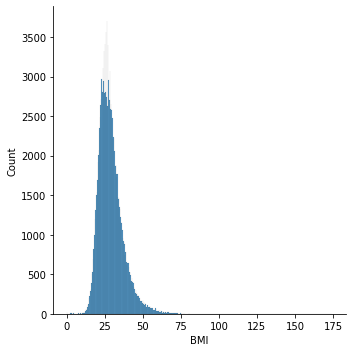

In [63]:
sns.displot(pts, x='BMI')

In [83]:
pts_final = pts[['patientunitstayid',
                 'gender', 
                 'age', 
                 'ethnicity',
                 'BMI', 
                 'actualventdays',
                 'ICU_duration',
                 'gcs_score', 
                 'apachescore', 
                 'from_OR',
                 'heartrate',
                 'orderedprotocols',
                 'teachingstatus',
                 'numbedscategory',
                 'opioid', 
                 'nsaid',
                 'painmeds']]

In [84]:
pts_final.head()

,patientunitstayid,gender,age,ethnicity,BMI,actualventdays,ICU_duration,gcs_score,apachescore,from_OR,heartrate,orderedprotocols,teachingstatus,numbedscategory,opioid,nsaid,painmeds
0,154752,Male,53.0,Caucasian,33.898903,0.0,1.130556,3.0,86.0,False,70.0,[Tissue Plasminogen Activator (tPA)],t,>= 500,True,True,True
1,156771,Female,88.0,Caucasian,27.813945,0.0,0.512500,14.0,42.0,False,60.0,[Tissue Plasminogen Activator (tPA)],f,100 - 249,True,True,True
2,173247,Female,81.0,Caucasian,37.592716,0.0,3.273611,15.0,42.0,False,72.0,[Tissue Plasminogen Activator (tPA)],t,>= 500,False,True,True
3,196674,Male,80.0,NaN,29.722411,0.0,1.912500,15.0,44.0,False,56.0,[Tissue Plasminogen Activator (tPA)],t,>= 500,False,True,True
4,196675,Male,80.0,NaN,29.756932,1.0,3.079167,12.0,46.0,False,87.0,[Tissue Plasminogen Activator (tPA)],t,>= 500,False,False,False


In [85]:
pts_final.to_csv('final_patients.csv')

In [86]:
pts_final = pd.merge(pts_final, opi_stat, on=['patientunitstayid'], how = 'left')
pts_final.head()

,patientunitstayid,gender,age,ethnicity,BMI,actualventdays,ICU_duration,gcs_score,apachescore,from_OR,heartrate,orderedprotocols,teachingstatus,numbedscategory,opioid,nsaid,painmeds,mme_per_day
0,154752,Male,53.0,Caucasian,33.898903,0.0,1.130556,3.0,86.0,False,70.0,[Tissue Plasminogen Activator (tPA)],t,>= 500,True,True,True,6.0
1,156771,Female,88.0,Caucasian,27.813945,0.0,0.512500,14.0,42.0,False,60.0,[Tissue Plasminogen Activator (tPA)],f,100 - 249,True,True,True,NaN
2,173247,Female,81.0,Caucasian,37.592716,0.0,3.273611,15.0,42.0,False,72.0,[Tissue Plasminogen Activator (tPA)],t,>= 500,False,True,True,NaN
3,196674,Male,80.0,NaN,29.722411,0.0,1.912500,15.0,44.0,False,56.0,[Tissue Plasminogen Activator (tPA)],t,>= 500,False,True,True,NaN
4,196675,Male,80.0,NaN,29.756932,1.0,3.079167,12.0,46.0,False,87.0,[Tissue Plasminogen Activator (tPA)],t,>= 500,False,False,False,NaN


In [87]:
pts_final.mme_per_day.fillna(0.0,inplace=True)

In [88]:
pts_final.dropna(inplace=True)

In [89]:
pts_final["painmeds"] = pts_final["painmeds"].astype(int)
pts_final["opioid"] = pts_final["opioid"].astype(int)
pts_final["nsaid"] = pts_final["nsaid"].astype(int)
pts_final["from_OR"] = pts_final["from_OR"].astype(int)
#pts_final["hr_over100"] = pts_final["hr_over100"].astype(int)

In [90]:
pts_final.teachingstatus.replace('t', 1, inplace=True)
pts_final.teachingstatus.replace('f', 0, inplace=True)

pts_final.gender.replace('Male', 1, inplace=True)
pts_final.gender.replace('Female', 0, inplace=True)

In [91]:
pts_final.head()

,patientunitstayid,gender,age,ethnicity,BMI,actualventdays,ICU_duration,gcs_score,apachescore,from_OR,heartrate,orderedprotocols,teachingstatus,numbedscategory,opioid,nsaid,painmeds,mme_per_day
0,154752,1,53.0,Caucasian,33.898903,0.0,1.130556,3.0,86.0,0,70.0,[Tissue Plasminogen Activator (tPA)],1,>= 500,1,1,1,6.0
1,156771,0,88.0,Caucasian,27.813945,0.0,0.512500,14.0,42.0,0,60.0,[Tissue Plasminogen Activator (tPA)],0,100 - 249,1,1,1,0.0
2,173247,0,81.0,Caucasian,37.592716,0.0,3.273611,15.0,42.0,0,72.0,[Tissue Plasminogen Activator (tPA)],1,>= 500,0,1,1,0.0
5,211851,0,48.0,Caucasian,23.612229,0.0,2.702778,15.0,25.0,0,68.0,[Tissue Plasminogen Activator (tPA)],0,<100,1,1,1,79.8
6,222701,1,51.0,Hispanic,44.089998,3.0,1.840278,15.0,25.0,0,98.0,[Tissue Plasminogen Activator (tPA)],1,>= 500,0,1,1,0.0


In [92]:
pts_final.to_csv('pts_no_dummies.csv')

In [100]:
pts_final = pd.get_dummies(pts_final, columns = ['numbedscategory'], drop_first = False)
pts_final = pd.get_dummies(pts_final, columns = ['ethnicity'], drop_first = False)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
# one hot ecoding from list
mlb = MultiLabelBinarizer()
pts_final = pts_final.join(pd.DataFrame(mlb.fit_transform(pts_final.pop('orderedprotocols')), columns=mlb.classes_, index=pts_final.index))

In [102]:
pts_final.head()

,patientunitstayid,gender,age,BMI,actualventdays,ICU_duration,gcs_score,apachescore,from_OR,heartrate,teachingstatus,opioid,nsaid,painmeds,mme_per_day,Antibiotic cycling,Cerebral vasospasm prevention/therapy,Congestive Heart Failure (CHF),Electrolyte replacement,End of life,Glucose control,Hypothermia,Lung protective ventilation,Myocardial infarction,Other,Pressure ulcer prophylaxis,Sedation,Sepsis bundle,Spinal precautions,Steroid taper,Tissue Plasminogen Activator (tPA),Ventilator bundle,Ventilator wean,numbedscategory_100 - 249,numbedscategory_250 - 499,numbedscategory_<100,numbedscategory_>= 500,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown
0,154752,1,53.0,33.898903,0.0,1.130556,3.0,86.0,0,70.0,1,1,1,1,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
1,156771,0,88.0,27.813945,0.0,0.512500,14.0,42.0,0,60.0,0,1,1,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0
2,173247,0,81.0,37.592716,0.0,3.273611,15.0,42.0,0,72.0,1,0,1,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
5,211851,0,48.0,23.612229,0.0,2.702778,15.0,25.0,0,68.0,0,1,1,1,79.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
6,222701,1,51.0,44.089998,3.0,1.840278,15.0,25.0,0,98.0,1,0,1,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0


In [103]:
pts_final.to_csv('pts_dummies.csv')

In [104]:
pts_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22098 entries, 0 to 25306
Data columns (total 43 columns):
patientunitstayid                        22098 non-null int64
gender                                   22098 non-null int64
age                                      22098 non-null float64
BMI                                      22098 non-null float64
actualventdays                           22098 non-null float64
ICU_duration                             22098 non-null float64
gcs_score                                22098 non-null float64
apachescore                              22098 non-null float64
from_OR                                  22098 non-null int64
heartrate                                22098 non-null float64
teachingstatus                           22098 non-null int64
opioid                                   22098 non-null int64
nsaid                                    22098 non-null int64
painmeds                                 22098 non-null int64
mme_per_d

In [99]:
pts_final.ethnicity.value_counts()

Caucasian           16285
Hispanic             2217
African American     2192
Other/Unknown         996
Asian                 314
Native American        94
Name: ethnicity, dtype: int64

___
### Multivariate Analysis

In [ ]:
def logreg_df(df, norm_cols, drop_cols, y_col, drop=False, reg=0):
    """
    df (string): CSV path.
    cat_cols (list): categorical columns to one-hot-encode.
    norm_cols (list): columns in df to normalize.
    drop_cols (list): columns to drop.
    y_col (string): variable of interest.
    """
    
    #df = pd.read_csv('df')
    #df = pd.get_dummies(df, columns = cat_cols, drop_first = drop)
    
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.model_selection import train_test_split
    
    from sklearn.linear_model import LogisticRegression
    from sklearn.datasets import load_iris
    
    df[norm_cols] = MinMaxScaler().fit_transform(df[norm_cols])
    
    if reg == 0:
        X = df.drop(columns = drop_cols)
        y = df[y_col]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
        
        log = LogisticRegression(penalty='l1',solver='liblinear')
        res = log.fit(X, y)
        
        #print(res)
        #print(res.coef_, res.intercept_)
        
        logit_model = sm.Logit(y, X)
        result = logit_model.fit(maxiter=1)

        print(result.summary2())
        
        params = result.params
        conf = result.conf_int()
        conf['Odds Ratio'] = params
        conf.columns = ['5%', '95%', 'Odds Ratio']
        print(np.exp(conf))
        print('==========================')
        
    elif reg == 1:
        X = df.drop(columns = drop_cols)
        y = df[y_col]
        X = sm.add_constant(X)
        
        ols_model = sm.OLS(y,X)
        result = ols_model.fit()
        
        print(result.summary())
        
        y_pred = result.predict(X)
    
    return result, y_pred, y, X

#### Painmeds by Ethnicity

In [ ]:
eth = ['ethnicity_Caucasian', 'ethnicity_African American', 'ethnicity_Asian',
      'ethnicity_Hispanic', 'ethnicity_Native American', 'ethnicity_Other/Unknown']

for i in eth:
    norm = ['actualventdays','age', 'gcs_score', 'apachescore']
    dp = ['opioid', 'nsaid', 'patientunitstayid','painmeds','mme_per_day',i]
    
    print("Compared to ", i)
    logreg_df(pts_final, norm, dp, 'painmeds')

In [ ]:
# In the above Caucasian baseline, there was no significance with African Americans, so why is it not both ways?

In [ ]:
# basically the above is saying compared to caucasians, hispanic and native american are signiciant 
# - both are more likely to receive pain meds

#### Ethnicity vs. Receiving Opioids

In [ ]:
eth = ['ethnicity_Caucasian', 'ethnicity_African American', 'ethnicity_Asian',
      'ethnicity_Hispanic', 'ethnicity_Native American', 'ethnicity_Other/Unknown']

for i in eth:
    norm = ['actualventdays','age','gcs_score', 'apachescore']
    dp = ['patientunitstayid','painmeds','opioid', i]
    
    print("Compared to ", i)
    logreg_df(pts_final, norm, dp, 'opioid', reg=0)

#### Ethnicity vs. MME

In [ ]:
eth = ['ethnicity_Caucasian', 'ethnicity_African American', 'ethnicity_Asian',
      'ethnicity_Hispanic', 'ethnicity_Native American', 'ethnicity_Other/Unknown']

models = []

for i in eth:
    norm = ['actualventdays','age', 'gcs_score', 'apachescore']
    dp = ['mme_per_day','patientunitstayid','painmeds','opioid', i]
    
    print("Compared to ", i)
    ols, y_pred, y_true, X = logreg_df(pts_final, norm, dp, 'mme_per_day', reg=1)
    models.append((y_pred, y_true, X))

In [ ]:
plt.figure(figsize=(14, 4.5))
plt.plot(models[0][0], label="OLS", alpha=0.5)
plt.plot(models[0][1], label="True", alpha=0.5)
plt.legend(loc='best')
plt.xlabel('Patient Number')
plt.ylabel('MME per Day')

#### Figures

In [ ]:
pts_figs = pd.read_csv('pts_no_dummies.csv')
pts_figs.head()

In [ ]:
plt.figure(figsize=(14, 4.5))
sns.barplot(x='ethnicity',y='painmeds',data=pts_figs, estimator=np.mean)
plt.xlabel('Patient Ethnicity')
plt.ylabel('Proportion Receiving Pain Medications')

In [ ]:
plt.figure(figsize=(14, 4.5))
sns.barplot(x='ethnicity',y='nsaid',data=pts_figs, estimator=np.mean)
plt.xlabel('Patient Ethnicity')
plt.ylabel('Proportion Receiving NSAIDs')

In [ ]:
plt.figure(figsize=(14, 4.5))
sns.barplot(x='ethnicity',y='opioid',data=pts_figs, estimator=np.mean)
plt.xlabel('Patient Ethnicity')
plt.ylabel('Proportion Receiving Opioids')

In [ ]:
plt.figure(figsize=(14, 4.5))
sns.barplot(x='ethnicity',y='mme_per_day',data=pts_figs, estimator=np.mean)
plt.xlabel('Patient Ethnicity')
plt.ylabel('MME per Day')

___
### Other Models

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error

X = pts_final.drop(columns = ['mme_per_day','patientunitstayid','painmeds','opioid'])
y = pts_final['mme_per_day']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(X_train, y_train)

In [ ]:
y_pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

In [ ]:
# fake patient with figure

In [ ]:
# https://towardsdatascience.com/multiple-imputation-with-random-forests-in-python-dec83c0ac55b

In [ ]:
# apache, admit from OR, admissiondrug, 
# careplancareprovider -> pain management, comfort measures
# admission systolic +-90 (vitals, sort by unitstay, time and take the first recorded BP), heart rate +-100 
# GCS (apachepredvar, variable, motor, eyes, take sum)